<a href="https://colab.research.google.com/github/PietroC21/InstaFollowers/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from transformers import BertTokenizer,BertModel, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.is_available()
seed_val = 17
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [2]:
def embedding(model , input_id, attention_masks):
    with torch.no_grad():
        outputs = model(input_id, attention_mask=attention_masks)
    hidden_states = outputs.last_hidden_state
    #CLS contains all the information of the sentence so we use CLS token for embedding
    CLS_embedding = hidden_states[:,0,:]

    return CLS_embedding

In [3]:
# Load the dataset
df = pd.read_csv('https://www.cs.fsu.edu/~liux/courses/deepRL/assignments/amazon_reviews.csv')
model = BertModel.from_pretrained('bert-base-uncased')
model.to("cuda")

df = df.dropna()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['overall'], test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the input texts
train_input_ids = []
train_attention_masks = []

for text in X_train:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        truncation = True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])


train_input_ids = torch.stack(train_input_ids).squeeze(1)
train_attention_masks = torch.stack(train_attention_masks).squeeze(1)

test_input_ids = []
test_attention_masks = []
for text in X_test:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        truncation = True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.stack(test_input_ids).squeeze(1)
test_attention_masks = torch.stack(test_attention_masks).squeeze(1)
# Combine the input_ids and attention_masks into a single feature vector
#X_test_vectorized = torch.cat((torch.stack(test_input_ids), torch.stack(test_attention_masks)), dim=1).view(len(X_test), -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [4]:
train_input_ids = train_input_ids.to(next(model.parameters()).device)
train_attention_masks = train_attention_masks.to(next(model.parameters()).device)

X_train_vectorized =  embedding(model, train_input_ids[:1000], train_attention_masks[:1000])
test =  embedding(model, train_input_ids[1000:2000], train_attention_masks[1000:2000] )
test2 =  embedding(model, train_input_ids[2000:3000], train_attention_masks[2000:3000] )

In [10]:
test_input_ids = test_input_ids.to(next(model.parameters()).device)
test_attention_masks = test_attention_masks.to(next(model.parameters()).device)

X_test_vectorized =  embedding(model, test_input_ids, test_attention_masks)

In [7]:
X_train_vectorized = torch.concat((X_train_vectorized,torch.concat((test,test2),0)),0)

In [15]:
X_test_vectorized = X_test_vectorized.cpu().numpy()

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Initialize the Logistic Regression
clf = LogisticRegression(random_state=42,C=0.1,max_iter = 5000 )
clf.fit(X_train_vectorized, y_train[:3000])

test_accuracy = clf.score(X_test_vectorized, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

Test accuracy: 0.80


<Figure size 1000x600 with 0 Axes>

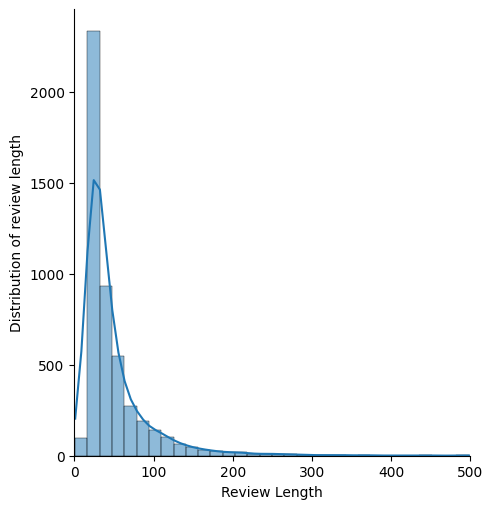

In [36]:
reviews = df['reviewText'].to_list()
lenght = np.array([len(x.split()) for x in reviews])
plt.figure(figsize=(10, 6))
sns.displot(lenght,kde=True, bins=100)
plt.xlim(0, 500)
plt.xlabel('Review Length')
plt.ylabel('Distribution of review length')
plt.show()